In [2]:
"""
    Package Installation
"""
__author__ = "SakibApon"
__email__ = "sakibapon7@gmail.com"

import os
import numpy as np 
import pandas as pd 

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
tf.gfile = tf.io.gfile

import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau

SEED = 1337

### Preprocessed Dataset Input

In [21]:
#loading datasets
dataset_01 = pd.read_csv("/kaggle/input/banfakenews/LabeledAuthentic-7K.csv")
dataset_02 = pd.read_csv("/kaggle/input/banfakenews/LabeledFake-1K.csv")

# combining two datasets
df_train_ =  pd.concat([dataset_01, dataset_02])
print(len(df_train_))
df_train_.head()

8501


,articleID,domain,date,category,source,relation,headline,content,label,F-type
0,1,bd-pratidin.com,2018-09-20 08:16:43,Sports,আফগান ক্রিকেট বোর্ড (এসিবি) প্রধান,Related,হঠাৎ আফগান ক্রিকেট বোর্ড প্রধানের পদত্যাগ,ক্রিকেট বিশ্বের নতুন চমকের নাম আফগানিস্তান। কয়...,1.0,NaN
1,2,jugantor.com,2018-09-20 20:20:20,Sports,Reporter,Related,টস হেরে বোলিংয়ে বাংলাদেশ,এশিয়া কাপের ষষ্ঠ ম্যাচে বাংলাদেশ দলের বিপক্ষে ...,1.0,NaN
2,3,bd24live.com,2018-09-20 16:39:40,National,Reporter,Related,রাজধানীতে বিশেষ অভিযানে আটক ৪৩,রাজধানীতে মাদক বিরোধী বিশেষ অভিযান পরিচালনা কর...,1.0,NaN
3,4,bd24live.com,2018-09-19 18:27:56,National,জননিরাপত্তা বিভাগের সচিব,Related,উস্কানি রোধে নজরদারি থাকবে সামাজিক যোগাযোগ মাধ...,সনাতন ধর্মাবলম্বীদের সবচেয়ে বড় ধর্মীয় উৎসব দুর...,1.0,NaN
4,5,somoynews.tv,2018-09-20 10:15:28,Finance,পেট্রোল পাম্প মালিক সমিতি সভাপতি,Related,"'যেখানে তেল আসত ৭ দিনে, এখন তা আসবে অতি দ্রুত'",ভারত থেকে পাইপ লাইনের মাধ্যমে সরাসরি দেশে জ্বা...,1.0,NaN


In [22]:
df_train = df_train_[['headline', 'label']]
print(len(df_train))
df_train.head()

8501


,headline,label
0,হঠাৎ আফগান ক্রিকেট বোর্ড প্রধানের পদত্যাগ,1.0
1,টস হেরে বোলিংয়ে বাংলাদেশ,1.0
2,রাজধানীতে বিশেষ অভিযানে আটক ৪৩,1.0
3,উস্কানি রোধে নজরদারি থাকবে সামাজিক যোগাযোগ মাধ...,1.0
4,"'যেখানে তেল আসত ৭ দিনে, এখন তা আসবে অতি দ্রুত'",1.0


In [23]:
df_train.rename(columns={'headline': 'Comments',  'label': 'Label'},  inplace=True, errors='raise')
df_train.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Comments,Label
0,হঠাৎ আফগান ক্রিকেট বোর্ড প্রধানের পদত্যাগ,1.0
1,টস হেরে বোলিংয়ে বাংলাদেশ,1.0
2,রাজধানীতে বিশেষ অভিযানে আটক ৪৩,1.0
3,উস্কানি রোধে নজরদারি থাকবে সামাজিক যোগাযোগ মাধ...,1.0
4,"'যেখানে তেল আসত ৭ দিনে, এখন তা আসবে অতি দ্রুত'",1.0


In [24]:
df_train.to_csv("processed.csv", index=False)

In [25]:
df_train = pd.read_csv("./processed.csv")
df_train.head()

,Comments,Label
0,হঠাৎ আফগান ক্রিকেট বোর্ড প্রধানের পদত্যাগ,1.0
1,টস হেরে বোলিংয়ে বাংলাদেশ,1.0
2,রাজধানীতে বিশেষ অভিযানে আটক ৪৩,1.0
3,উস্কানি রোধে নজরদারি থাকবে সামাজিক যোগাযোগ মাধ...,1.0
4,"'যেখানে তেল আসত ৭ দিনে, এখন তা আসবে অতি দ্রুত'",1.0


### K-fold

In [27]:
K = 4 # K-fold
skf = StratifiedKFold(n_splits= K, random_state=SEED, shuffle=True)

DISASTER = df_train['Label'] == 1
print('Whole Training Set Shape = {}'.format(df_train.shape))
print('Whole Training Set Unique keyword Count = {}'.format(df_train['Label'].nunique()))
print('Whole Training Set Target Rate (Disaster) {}/{} (Not Disaster)'.format(df_train[DISASTER]['Label'].count(), df_train[~DISASTER]['Label'].count()))

for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train['Comments'], df_train['Label']), 1):
    print('\nFold {} Training Set Shape = {} - Validation Set Shape = {}'.format(fold, df_train.loc[trn_idx, 'Comments'].shape, df_train.loc[val_idx, 'Comments'].shape))
    print('Fold {} Training Set Unique keyword Count = {} - Validation Set Unique keyword Count = {}'.format(fold, df_train.loc[trn_idx, 'Label'].nunique(), df_train.loc[val_idx, 'Label'].nunique()))    

Whole Training Set Shape = (8501, 2)
Whole Training Set Unique keyword Count = 2
Whole Training Set Target Rate (Disaster) 7202/1299 (Not Disaster)

Fold 1 Training Set Shape = (6375,) - Validation Set Shape = (2126,)
Fold 1 Training Set Unique keyword Count = 2 - Validation Set Unique keyword Count = 2

Fold 2 Training Set Shape = (6376,) - Validation Set Shape = (2125,)
Fold 2 Training Set Unique keyword Count = 2 - Validation Set Unique keyword Count = 2

Fold 3 Training Set Shape = (6376,) - Validation Set Shape = (2125,)
Fold 3 Training Set Unique keyword Count = 2 - Validation Set Unique keyword Count = 2

Fold 4 Training Set Shape = (6376,) - Validation Set Shape = (2125,)
Fold 4 Training Set Unique keyword Count = 2 - Validation Set Unique keyword Count = 2


# BERT 

### Module Installation 

In [14]:
!pip install bert-tensorflow==1.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.4/67.4 kB 764.6 kB/s eta 0:00:00a 0:00:01


### BERT Layer

In [16]:
%%time
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)

2022-08-22 17:57:10.937598: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 17:57:11.060019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 17:57:11.060822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 17:57:11.062271: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

CPU times: user 9.76 s, sys: 2.51 s, total: 12.3 s
Wall time: 14.7 s


### BERT Architecture

In [28]:
class DisasterDetector:
    
    def __init__(self, bert_layer, max_seq_length=128, lr=0.0001, epochs=15, batch_size=32):
        
        # BERT and Tokenization params
        self.bert_layer = bert_layer
        
        self.max_seq_length = max_seq_length        
        vocab_file = self.bert_layer.resolved_object.vocab_file.asset_path.numpy()
        do_lower_case = self.bert_layer.resolved_object.do_lower_case.numpy()
        self.tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
        
        # Learning control params
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        
        self.models = []
        self.scores = {}
        
        
    def encode(self, texts):
                
        all_tokens = []
        all_masks = []
        all_segments = []

        for text in texts:
            text = self.tokenizer.tokenize(text)
            text = text[:self.max_seq_length - 2]
            input_sequence = ['[CLS]'] + text + ['[SEP]']
            pad_len = self.max_seq_length - len(input_sequence)

            tokens = self.tokenizer.convert_tokens_to_ids(input_sequence)
            tokens += [0] * pad_len
            pad_masks = [1] * len(input_sequence) + [0] * pad_len
            segment_ids = [0] * self.max_seq_length

            all_tokens.append(tokens)
            all_masks.append(pad_masks)
            all_segments.append(segment_ids)

        return np.array(all_tokens), np.array(all_masks), np.array(all_segments)
    
    
    def build_model(self):
        
        input_word_ids = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_word_ids')
        input_mask = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_mask')
        segment_ids = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='segment_ids')    
        
        pooled_output, sequence_output = self.bert_layer([input_word_ids, input_mask, segment_ids])   
        clf_output = sequence_output[:, 0, :]
        out = Dense(1, activation='sigmoid')(clf_output)
        
        model = Model(inputs = [input_word_ids, input_mask, segment_ids], outputs=out)
        optimizer = SGD(learning_rate=self.lr, momentum=0.8)
        metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
        #tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()
        model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = metrics)
        
        return model
    
    
    def train(self, X):
        
        for fold, (trn_idx, val_idx) in enumerate(skf.split(X['Comments'], X['Label'])):
            
            print('\nFold {}\n'.format(fold))
        
            X_trn_encoded = self.encode(X.loc[trn_idx, 'Comments'].str.lower())
            y_trn = X.loc[trn_idx, 'Label']
            X_val_encoded = self.encode(X.loc[val_idx, 'Comments'].str.lower())
            y_val = X.loc[val_idx, 'Label']
        
            # Callbacks
            metrics = ClassificationReport(train_data=(X_trn_encoded, y_trn), validation_data=(X_val_encoded, y_val))
            
            checkpoint = ModelCheckpoint('SarcasmBERT.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
            earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, restore_best_weights=True)
            learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.2, min_lr=0.001)
            
            callbacks = [earlystop, checkpoint, learning_rate_reduction, metrics]
            
            # Model
            model = self.build_model()        
            history = model.fit(X_trn_encoded, y_trn, validation_data=(X_val_encoded, y_val), callbacks = callbacks, epochs=self.epochs, batch_size=self.batch_size)
            
            #plot_graphs(history, "accuracy")
            #plot_graphs(history, "loss")
            
            """y_pred = argmax(model.predict(X_val_encoded),axis=1)
            y_true = y_val
            target_names = ['class 0', 'class 1']
            print(classification_report(y_true, y_pred, target_names=target_names))

            cm = confusion_matrix(y_true, y_pred)
            f = sns.heatmap(cm, annot=True, fmt='d')
            
            #cm(y_pred)
            
            probs = model.predict_proba(X_val_encoded)
            preds = probs[:,0]
            fpr, tpr, threshold = metrics.roc_curve(testing_labels, preds)
            roc_auc = metrics.auc(fpr, tpr)

            import matplotlib.pyplot as plt
            plt.title('Receiver Operating Characteristic')
            plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
            plt.legend(loc = 'lower right')
            plt.plot([0, 1], [0, 1],'r--')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.show()
            
            #roc(probs)"""
            
            self.models.append(model)
            self.scores[fold] = {
                'train': {
                    'precision': metrics.train_precision_scores,
                    'recall': metrics.train_recall_scores,
                    'f1': metrics.train_f1_scores                    
                },
                'validation': {
                    'precision': metrics.val_precision_scores,
                    'recall': metrics.val_recall_scores,
                    'f1': metrics.val_f1_scores                    
                }
            }
                    
                
    def plot_learning_curve(self):
        
        fig, axes = plt.subplots(nrows=K, ncols=2, figsize=(20, K * 6), dpi=100)
    
        for i in range(K):
            
            # Classification Report curve
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[i].history.history['val_accuracy'], ax=axes[i][0], label='val_accuracy')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['precision'], ax=axes[i][0], label='val_precision')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['recall'], ax=axes[i][0], label='val_recall')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['f1'], ax=axes[i][0], label='val_f1')        

            axes[i][0].legend() 
            axes[i][0].set_title('Fold {} Validation Classification Report'.format(i), fontsize=14)

            # Loss curve
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['loss'], ax=axes[i][1], label='train_loss')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['val_loss'], ax=axes[i][1], label='val_loss')

            axes[i][1].legend() 
            axes[i][1].set_title('Fold {} Train / Validation Loss'.format(i), fontsize=14)

            for j in range(2):
                axes[i][j].set_xlabel('Epoch', size=12)
                axes[i][j].tick_params(axis='x', labelsize=12)
                axes[i][j].tick_params(axis='y', labelsize=12)

        plt.show()
        
        
    def predict(self, X):
        
        X_test_encoded = self.encode(X['Comments'].str.lower())
        y_pred = np.zeros((X_test_encoded[0].shape[0], 1))

        for model in self.models:
            y_pred += model.predict(X_test_encoded) / len(self.models)

        return y_pred

### Classification Report on epoch end

In [29]:
class ClassificationReport(Callback):
    
    def __init__(self, train_data=(), validation_data=()):
        super(Callback, self).__init__()
        
        self.X_train, self.y_train = train_data
        self.train_precision_scores = []
        self.train_recall_scores = []
        self.train_f1_scores = []
        
        self.X_val, self.y_val = validation_data
        self.val_precision_scores = []
        self.val_recall_scores = []
        self.val_f1_scores = [] 
               
    def on_epoch_end(self, epoch, logs={}):
        train_predictions = np.round(self.model.predict(self.X_train, verbose=0))        
        train_precision = precision_score(self.y_train, train_predictions, average='macro')
        train_recall = recall_score(self.y_train, train_predictions, average='macro')
        train_f1 = f1_score(self.y_train, train_predictions, average='macro')
        self.train_precision_scores.append(train_precision)        
        self.train_recall_scores.append(train_recall)
        self.train_f1_scores.append(train_f1)
        
        val_predictions = np.round(self.model.predict(self.X_val, verbose=0))
        val_precision = precision_score(self.y_val, val_predictions, average='macro')
        val_recall = recall_score(self.y_val, val_predictions, average='macro')
        val_f1 = f1_score(self.y_val, val_predictions, average='macro')
        self.val_precision_scores.append(val_precision)        
        self.val_recall_scores.append(val_recall)        
        self.val_f1_scores.append(val_f1)
        
        print('\nEpoch: {} - Training Precision: {:.6} - Training Recall: {:.6} - Training F1: {:.6}'.format(epoch + 1, train_precision, train_recall, train_f1))
        print('Epoch: {} - Validation Precision: {:.6} - Validation Recall: {:.6} - Validation F1: {:.6}'.format(epoch + 1, val_precision, val_recall, val_f1))  

### Initialize Training

In [30]:
from bert import tokenization

clf = DisasterDetector(bert_layer, max_seq_length=128, lr = 0.0001, epochs = 10, batch_size = 32)
clf.train(df_train)


Fold 0



2022-08-22 18:00:05.126692: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
200/200 [==============================] - 116s 505ms/step - loss: 0.4065 - accuracy: 0.8469 - precision: 0.8472 - recall: 0.9996 - auc: 0.6987 - val_loss: 0.3541 - val_accuracy: 0.8467 - val_precision: 0.8471 - val_recall: 0.9994 - val_auc: 0.7987

Epoch 00001: val_loss improved from inf to 0.35407, saving model to SarcasmBERT.h5

Epoch: 1 - Training Precision: 0.423596 - Training Recall: 0.499907 - Training F1: 0.458599
Epoch: 1 - Validation Precision: 0.423529 - Validation Recall: 0.499722 - Validation F1: 0.458482
Epoch 2/10
200/200 [==============================] - 99s 496ms/step - loss: 0.3111 - accuracy: 0.8820 - precision: 0.8840 - recall: 0.9907 - auc: 0.8362 - val_loss: 0.2789 - val_accuracy: 0.9069 - val_precision: 0.9104 - val_recall: 0.9872 - val_auc: 0.8578

Epoch 00002: val_loss improved from 0.35407 to 0.27890, saving model to SarcasmBERT.h5

Epoch: 2 - Training Precision: 0.875152 - Training Recall: 0.716741 - Training F1: 0.765205
Epoch: 2 - Validation Pre

### Evaluation Graphs

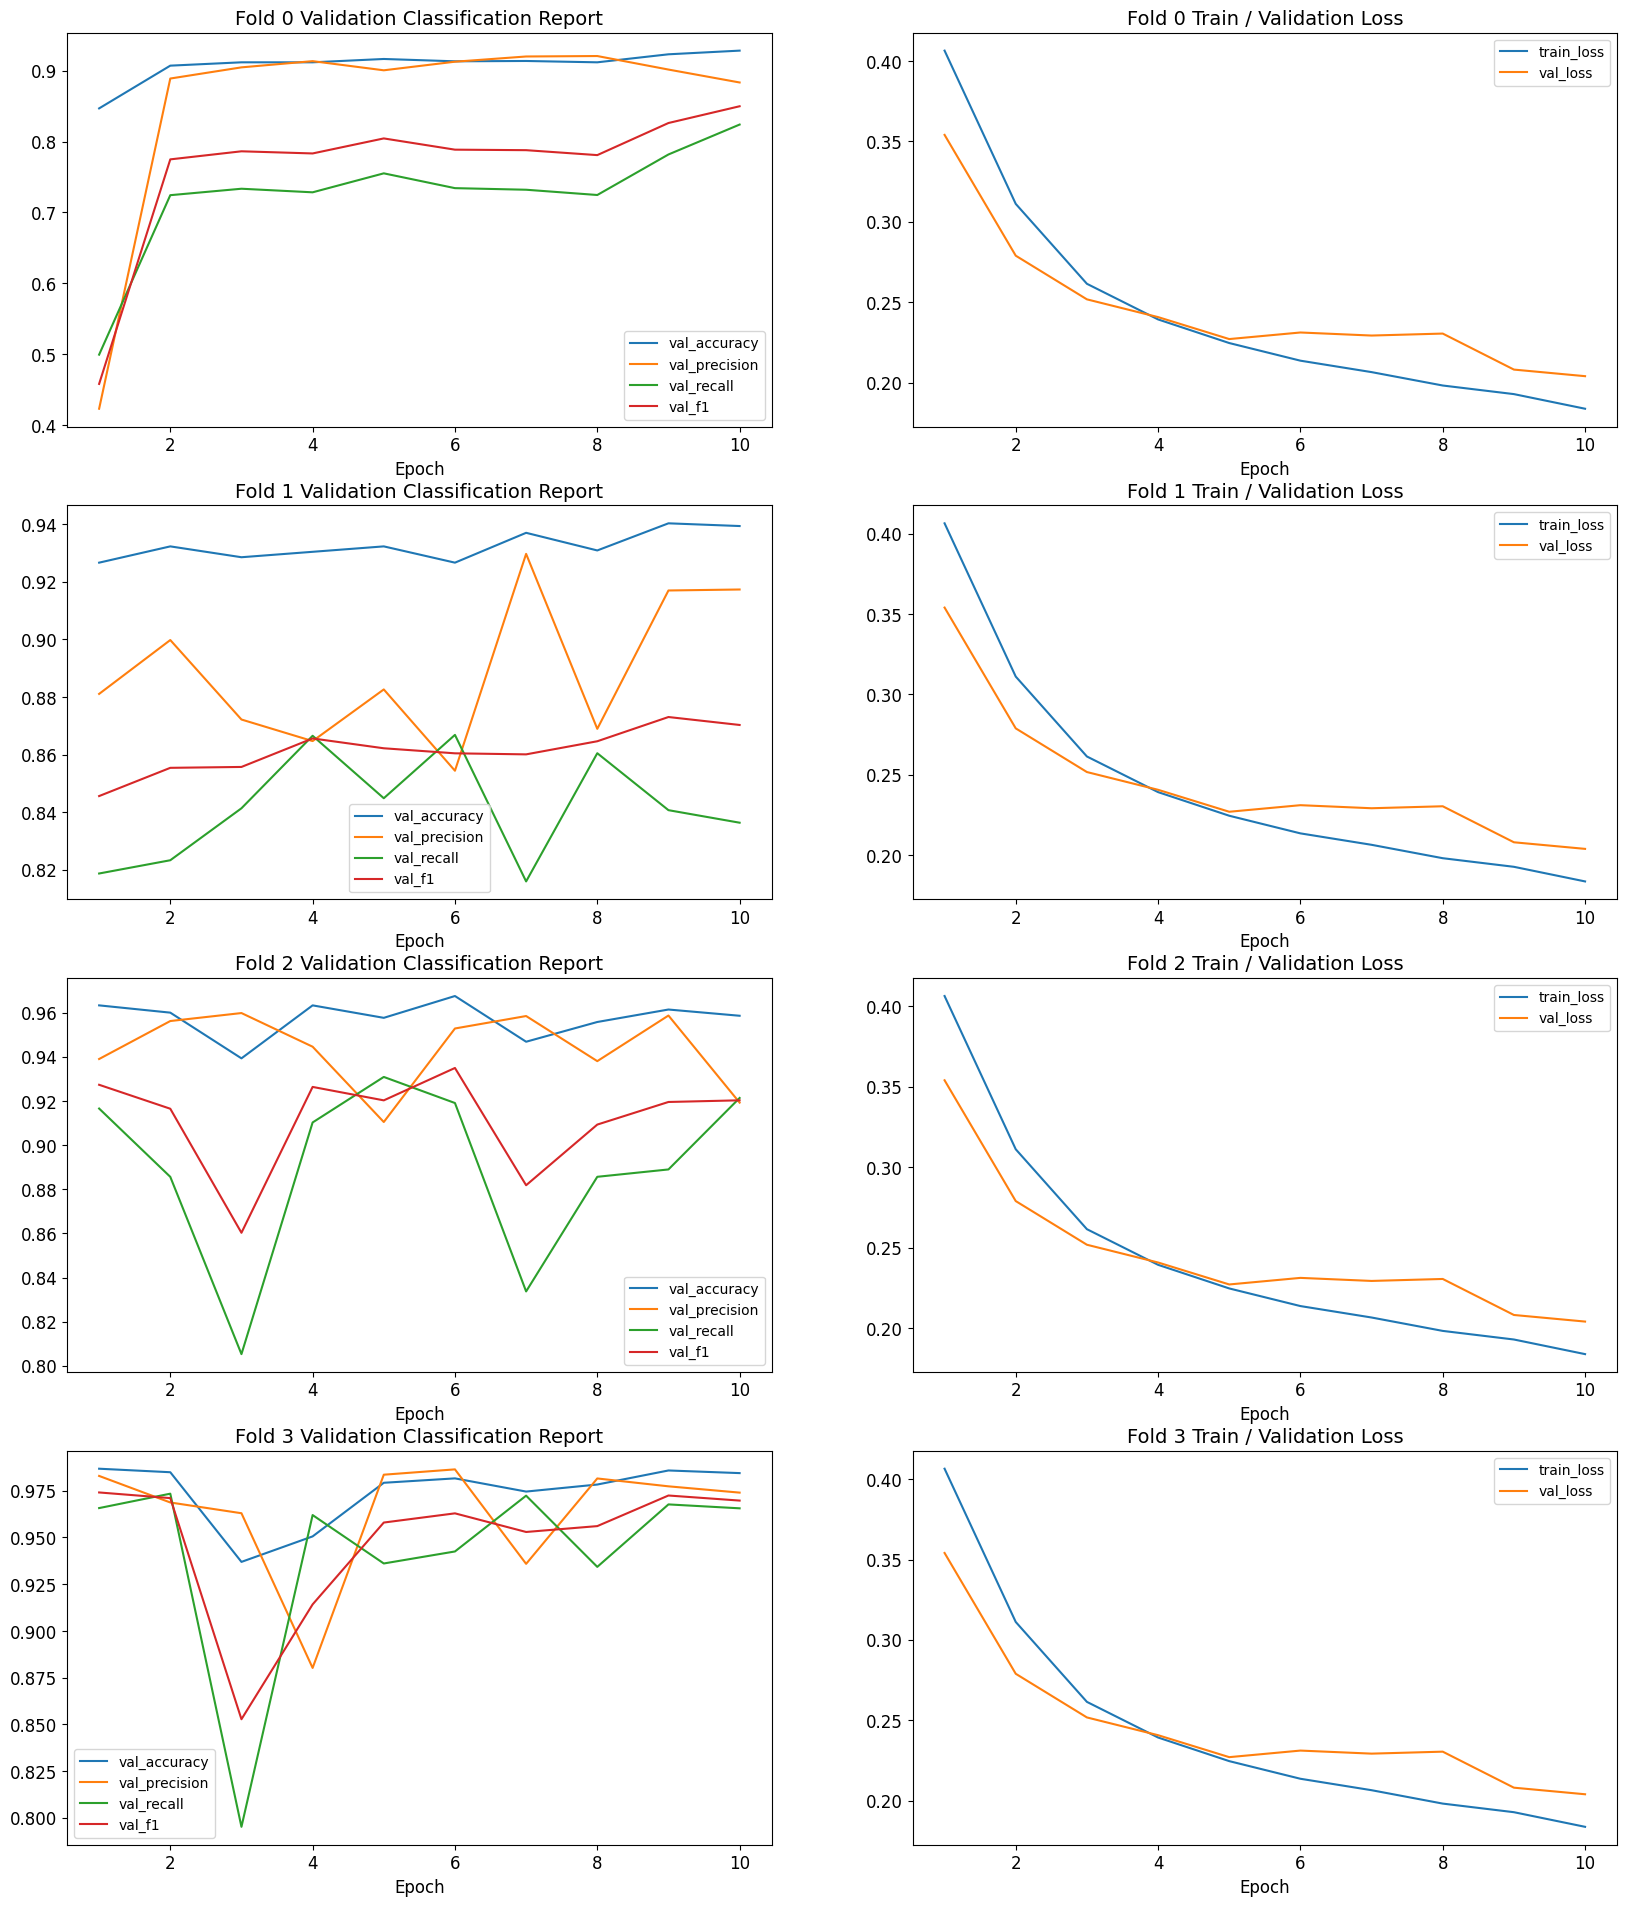

In [31]:
clf.plot_learning_curve()